<a href="https://www.kaggle.com/code/saibalpatra/classification-of-normal-and-oscc-images?scriptVersionId=209607408" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

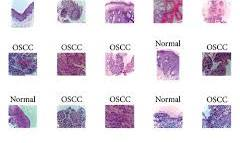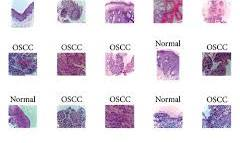

## Classification of Normal and OSCC (Oral Squamous Cell Carcinoma) Images Using Transfer Learning with Xception, MobileNet, and Multi-Head Attention Mechanism

### Data Preparation

In [4]:
## Listing all Libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import cv2

import time
import shutil
import pathlib, itertools
from PIL import Image

## importing necessary ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## importing Deep Learning Modules
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")


In [5]:
import pandas as pd
import numpy as np
import os

dataset_path = "/kaggle/input/dataset/train"
categories = ['Normal','OSCC']
data = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    label = category

    for file_name in os.listdir(folder_path):
        if file_name.endswith(('.png', 'jpeg', '.jpg')):
            file_path = os.path.join(folder_path, file_name)
            data.append([file_path,label])

## final data 
data = pd.DataFrame(
    data,
    columns = ['file_path', 'labels']
)

data.head()
    

,file_path,labels
0,/kaggle/input/dataset/train/Normal/aug_506_590...,Normal
1,/kaggle/input/dataset/train/Normal/aug_35_9199...,Normal
2,/kaggle/input/dataset/train/Normal/aug_263_936...,Normal
3,/kaggle/input/dataset/train/Normal/aug_432_454...,Normal
4,/kaggle/input/dataset/train/Normal/aug_70_904.jpg,Normal


In [6]:
## shape of the data
data.shape

(4946, 2)

In [7]:
## Columns
data.columns

Index(['file_path', 'labels'], dtype='object')

In [8]:
## Checking if any duplicacy in the data
data.duplicated().sum()

0

In [9]:
## Checking Null Values
data.isnull().sum()

file_path    0
labels       0
dtype: int64

In [10]:
## checking info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  4946 non-null   object
 1   labels     4946 non-null   object
dtypes: object(2)
memory usage: 77.4+ KB


In [11]:
## Labels
data['labels'].unique()

array(['Normal', 'OSCC'], dtype=object)

In [12]:
## Count of Each Labels
data['labels'].value_counts()

labels
OSCC      2511
Normal    2435
Name: count, dtype: int64

### Visualization of Data Aspects for Better Understanding

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

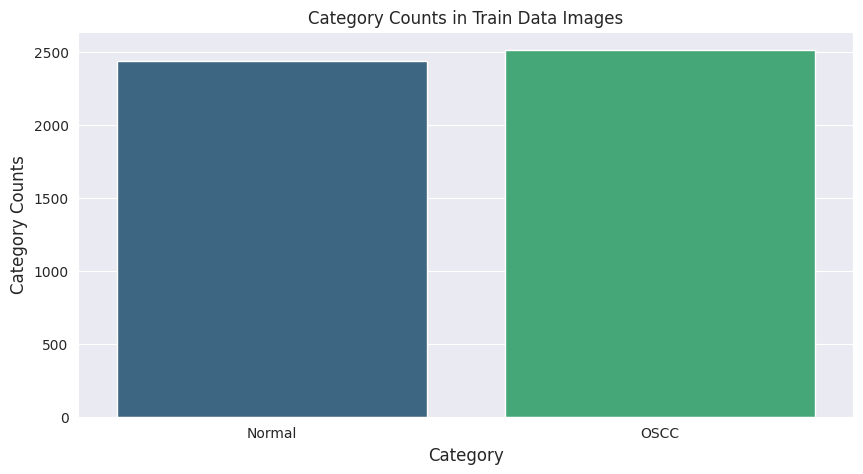

In [14]:
## Distribution of Images By Category
category_counts = data['labels'].value_counts()

## CountPlot from Sns
plt.figure(figsize = (10,5))
sns.countplot(data = data, x= 'labels', palette='viridis')
plt.xlabel("Category", size = 12)
plt.ylabel("Category Counts", size = 12)
plt.title("Category Counts in Train Data Images", size = 12)
plt.show()

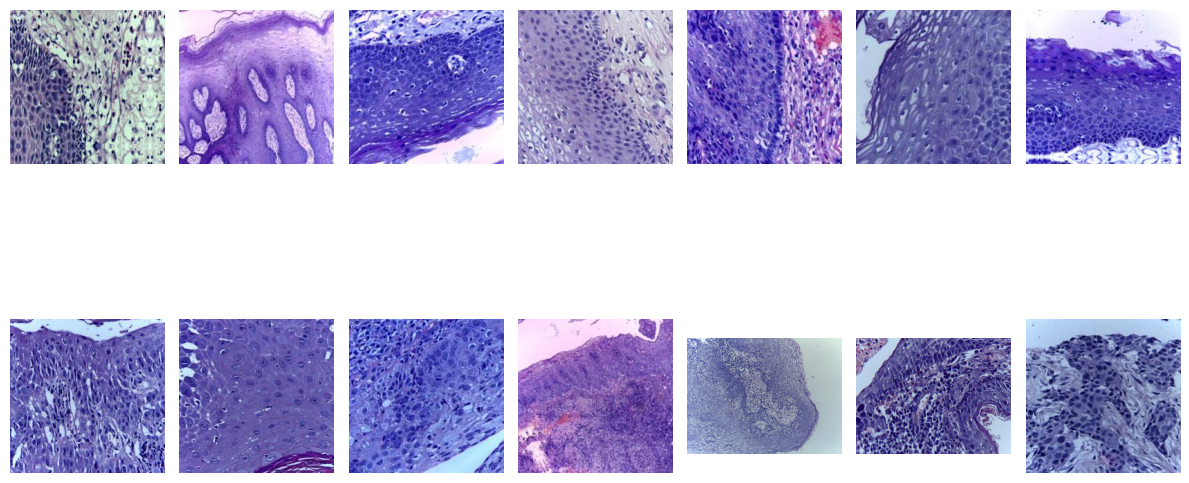

In [15]:
## Plotting the Actual Images

import cv2

num_samples = 7

fig,axes = plt.subplots(2, num_samples, figsize = (12,8))

for i, category in enumerate(data['labels'].unique()):
    category_images = data[data['labels'] == category].sample(num_samples)

    for j, image_path in enumerate(category_images['file_path']):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        if j==0:
            axes[i, j].set_ylabel(category, fontsize=14, rotation = 90)

plt.tight_layout()
plt.show()

### Preprocessing Data

In [16]:
## Encoding the Classes

label_encoder = LabelEncoder()
data['encoded_labels'] = label_encoder.fit_transform(data['labels'])

## Obersvering Label Encoders
label_encoder_classes = dict(zip(label_encoder.classes_,
                                label_encoder.transform(label_encoder.classes_)))
print("Label Encoder Class and Mapping : ")
print(label_encoder_classes)

Label Encoder Class and Mapping : 
{'Normal': 0, 'OSCC': 1}


#### Processing The Encoded Data

In [17]:
data['encoded_labels'].value_counts()
data['encoded_labels'] = data['encoded_labels'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       4946 non-null   object
 1   labels          4946 non-null   object
 2   encoded_labels  4946 non-null   object
dtypes: object(3)
memory usage: 116.0+ KB


In [18]:
## final data
data = data[['file_path', 'encoded_labels']]
data.shape

(4946, 2)

### `Training`, `Testing` and `Validation` Class

In [19]:
train_df, temp_df = train_test_split(
    data,
    train_size = 0.80,
    shuffle=True,
    random_state=42,
    stratify=data['encoded_labels']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size = .50,
    shuffle = True,
    random_state = 42,
    stratify=temp_df['encoded_labels']
)

## checking all splits shape
print(f"Training Data Shape : {train_df.shape},\n"
      f"Validation Data Shape : {val_df.shape},\n"
      f"Testing Data Shape : {test_df.shape}")

Training Data Shape : (3956, 2),
Validation Data Shape : (495, 2),
Testing Data Shape : (495, 2)


### Data Augumentation and Image Preprocessing

In [20]:
## Data Augumentation and Image Preprocessing
batch_size = 16
img_size = (299, 299)
channels = 3

img_shape = (img_size[0], img_size[1], channels)

## Normalization of Image Data
train_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

## Final Image Preparation
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'file_path',
    y_col = 'encoded_labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True,
    batch_size=batch_size
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col = 'file_path',
    y_col = 'encoded_labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False,
    batch_size=batch_size
)

val_data = test_gen.flow_from_dataframe(
    val_df,
    x_col = 'file_path',
    y_col = 'encoded_labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True,
    batch_size=batch_size
)

Found 3956 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


## Model Building and Model Configuration

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
     print("Using GPU")
else:
     print("Using CPU")

Using GPU


In [23]:
## Early Stopping Condition

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)

In [24]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, 
     GlobalAveragePooling2D, Dropout, BatchNormalization, 
     GaussianNoise, Input, MultiHeadAttention, Reshape
)

from tensorflow.keras.optimizers import Adam


### Model Building

In [25]:
def xception_model(input_shape, num_classes=2, learning_rate=0.0001):
    inputs = Input(shape=input_shape, name="InputLayer")
    base_model = Xception(
        weights='imagenet',
        input_tensor=inputs,
        include_top=False
    )
    base_model.trainable = False
    X = base_model.output
    height, width, channels = X.shape[1], X.shape[2], X.shape[3]
    X = Reshape((height * width, channels), name="ReshapeToSequence")(X)

    # Preparing data for Multi-Head Attention
    multihead_attention = MultiHeadAttention(
        num_heads=8,
        key_dim=channels,
        name="MultiHeadAttention"
    )(X, X)

    attention_output = Reshape((height, width, channels), name="ReshapeToSpatial")(multihead_attention)

    # Add Gaussian Noise
    X = GaussianNoise(0.25, name="GaussianNoise1")(attention_output)
    X = GlobalAveragePooling2D(name="GlobalAvgPooling1")(X)
    X = Dense(512, activation='relu', name="FullyConnected512")(X)
    X = BatchNormalization(name="BatchNormalization1")(X)
    X = GaussianNoise(0.25, name="GaussianNoise2")(X)
    X = Dropout(0.25, name="Dropout1")(X)
    outputs = Dense(1, activation='sigmoid', name="OutputLayer")(X)

    model = Model(inputs=inputs, outputs=outputs, name="XceptionAttention")

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [28]:
## Apllication of the Model

input_shape = (299, 299, 3)
cnn_model = xception_model(input_shape, num_classes=2, learning_rate=0.0001)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
## Running the Model
history = cnn_model.fit(
    train_data,
    validation_data = val_data,
    epochs = 50,
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/50


I0000 00:00:1732561151.852701     162 service.cc:145] XLA service 0x5832e6a9ebc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732561151.852760     162 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732561164.173173     162 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/248 ━━━━━━━━━━━━━━━━━━━━ 129s 438ms/step - accuracy: 0.7201 - loss: 0.6059 - val_accuracy: 0.8303 - val_loss: 0.3573
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step - accuracy: 0.8465 - loss: 0.3463 - val_accuracy: 0.8242 - val_loss: 0.3964
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step - accuracy: 0.8850 - loss: 0.2815 - val_accuracy: 0.7737 - val_loss: 0.7418
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 220ms/step - accuracy: 0.8958 - loss: 0.2657 - val_accuracy: 0.7818 - val_loss: 0.6322
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 220ms/step - accuracy: 0.9180 - loss: 0.2089 - val_accuracy: 0.8364 - val_loss: 0.4754
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 57s 223ms/step - accuracy: 0.9364 - loss: 0.1737 - val_accuracy: 0.8929 - val_loss: 0.3432
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 57s 224ms/step - accuracy: 0.9411 - loss: 0.1449 - val_accuracy: 0.9051 - val_loss: 0.3143
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 57s 224ms/step - accuracy: 0.9516 - loss: 0.1251 - va

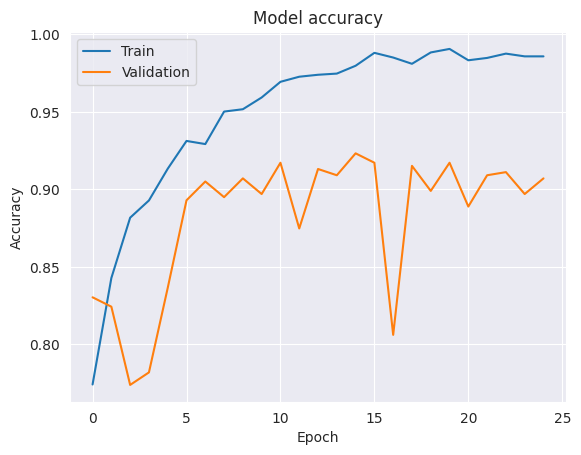

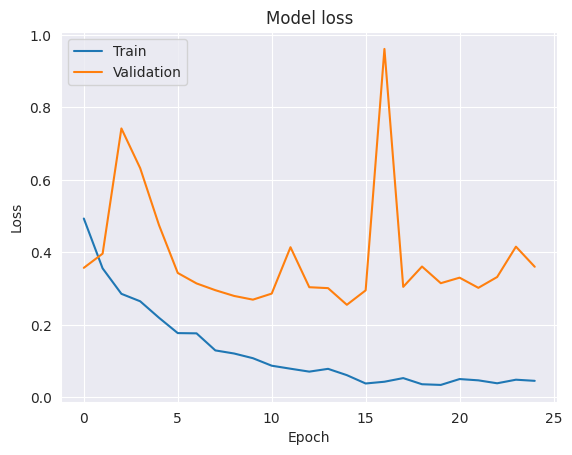

In [30]:
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.title('Model accuracy')
 plt.ylabel('Accuracy')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('Model loss')
 plt.ylabel('Loss')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()

### Classification Report/Summary

In [31]:
## Test Labels and Predicted Classes
test_labels = test_data.classes
prediction = cnn_model.predict(test_data)
predicted_classes = (prediction > 0.5).astype(int).reshape(-1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 411ms/step


In [32]:
## Report
report = classification_report(test_labels, predicted_classes, 
                              target_names = test_data.class_indices.keys())
print(report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       244
           1       0.91      0.89      0.90       251

    accuracy                           0.90       495
   macro avg       0.90      0.90      0.90       495
weighted avg       0.90      0.90      0.90       495



### Plotting `Confusion-Matrix`

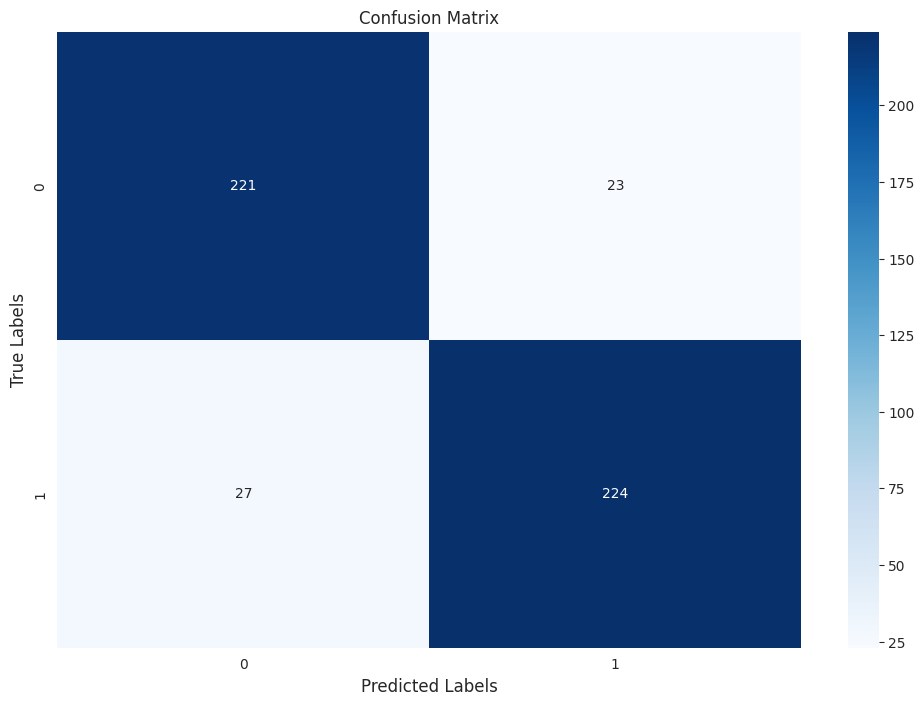

In [33]:
conf_matrix_1 = confusion_matrix(test_labels, predicted_classes)
## plotting the confusion matrix
plt.figure(figsize = (12,8))
sns.heatmap(
    conf_matrix_1,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    xticklabels=list(test_data.class_indices.keys()),
    yticklabels=list(test_data.class_indices.keys())
)
plt.title("Confusion Matrix", size = 12)
plt.xlabel("Predicted Labels", size = 12)
plt.ylabel("True Labels", size = 12)
plt.show()

### Model Building - `MobileNet`

In [34]:
## importing libraries for Implementation of MobileNet
from tensorflow.keras.applications import MobileNet

In [35]:
## Implementation of MobileNet Model

def mobilenet_model(input_shape, num_classes = 2, learning_rate = 0.0001):
    inputs = Input(input_shape, name = "Input_Layer")
    base_model = MobileNet(
        weights = 'imagenet',
        input_tensor = inputs,
        include_top = False
    )
    base_model.trainable = False
    X = base_model.output
    height, width, channels = X.shape[1], X.shape[2], X.shape[3]
    X = Reshape((
        height * width, channels), name = "Reshape_to_Sequence")(X)
    attention_output = MultiHeadAttention(
        num_heads = 8,
        key_dim = channels,
        name = "MultiHead_Attention"
    )(X,X)
    attention_output = Reshape((height, width, channels),
                              name = "Reshape_to_Spatial")(attention_output)
    X = GaussianNoise(0.25, name = "Gaussian_Noise_1")(attention_output)
    X = GlobalAveragePooling2D(name = "global_average_pooling_1")(X)
    X = Dense(512, activation = 'relu', name = "FC_512")(X)
    X = BatchNormalization(name = "batch_normalization_1")(X)
    X = GaussianNoise(0.25, name = "gaussian_noise_2")(X)
    X = Dropout(0.25, name = "dropout_1")(X)
    outputs = Dense(1, activation = 'sigmoid', name = "output_layer")(X)
    model = Model(inputs = inputs,
                    outputs = outputs,
                    name = "MobileNet_with_Attention")
    model.compile(
        optimizer = Adam(learning_rate = learning_rate),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    return model

In [36]:
## implementation of MobileNet Model
input_shape = (224, 224, 3)
mobilenet_model = mobilenet_model(input_shape = input_shape,
                                  learning_rate = 0.0001,
                                  num_classes = 2)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
## train,test,val data
## Data Augumentation and Image Preprocessing
batch_size = 16
img_size = (224,224)
channels = 3

img_shape = (img_size[0], img_size[1], channels)

## Normalization of Image Data
train_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

## Final Image Preparation
train_data_mobilenet = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'file_path',
    y_col = 'encoded_labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True,
    batch_size=batch_size
)

test_data_mobilenet = test_gen.flow_from_dataframe(
    test_df,
    x_col = 'file_path',
    y_col = 'encoded_labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False,
    batch_size=batch_size
)

val_data_mobilenet = test_gen.flow_from_dataframe(
    val_df,
    x_col = 'file_path',
    y_col = 'encoded_labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True,
    batch_size=batch_size
)

Found 3956 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


In [38]:
## Running and Testing the Model

history = mobilenet_model.fit(
    train_data_mobilenet,
    validation_data = val_data_mobilenet,
    epochs = 50,
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 67s 226ms/step - accuracy: 0.7703 - loss: 0.5489 - val_accuracy: 0.8828 - val_loss: 0.2857
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 49s 191ms/step - accuracy: 0.8709 - loss: 0.3033 - val_accuracy: 0.8949 - val_loss: 0.2967
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 49s 191ms/step - accuracy: 0.9077 - loss: 0.2220 - val_accuracy: 0.8667 - val_loss: 0.3100
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.9429 - loss: 0.1542 - val_accuracy: 0.9293 - val_loss: 0.2151
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.9754 - loss: 0.0751 - val_accuracy: 0.7374 - val_loss: 0.9965
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 187ms/step - accuracy: 0.9761 - loss: 0.0815 - val_accuracy: 0.8283 - val_loss: 0.6459
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - accuracy: 0.9759 - loss: 0.0731 - val_accuracy: 0.8889 - val_loss: 0.3692
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.9817 - loss: 0

### Model Evaluation

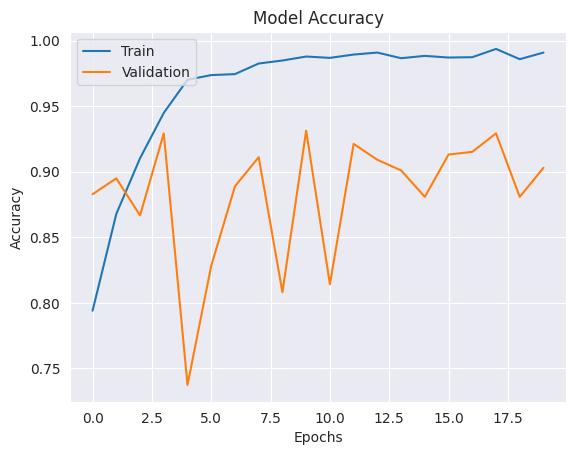

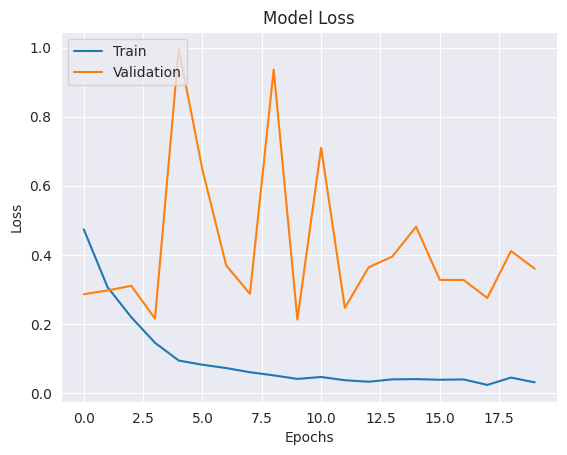

In [39]:
## plotting the Variation of Loss for Both Training and Validation Data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy", size = 12)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

### Classification Report

In [40]:
## prediction of results
test_labels = np.array(test_data_mobilenet.classes)
predictions = mobilenet_model.predict(test_data_mobilenet)
predicted_classes = (prediction > 0.5).astype(int).reshape(-1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step


In [41]:
## Classification Report
## Classification Report
report = classification_report(test_labels, predicted_classes,
                               target_names = list(test_data_mobilenet.class_indices.keys())
                              )
print(report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       244
           1       0.91      0.89      0.90       251

    accuracy                           0.90       495
   macro avg       0.90      0.90      0.90       495
weighted avg       0.90      0.90      0.90       495



### `Confusion-Matrix`

In [1]:
conf_matrix_2 = confusion_matrix(
    test_labels,
    predicted_classes
)
plt.figure(figsize = (12,8))
sns.heatmap(
    conf_matrix_2, 
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    xticklabels = list(test_data_mobilenet.class_indices.keys()),
    yticklabels = list(test_data_mobilenet.class_indices.keys())
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

NameError: name 'confusion_matrix' is not defined